# Проект 4

**Описание проекта**

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов**

*Тариф «Смарт»*

Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 3 рубля
сообщение: 3 рубля
1 Гб интернет-трафика: 200 рублей

*Тариф «Ультра»*

Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 1 рубль
сообщение: 1 рубль
1 Гб интернет-трафика: 150 рублей

>Примечание:
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Откроем файл с данными и изучим общую информацию одновременно подготавливая данные

Загрузим необходимые библиотеки.

In [1]:
from matplotlib import pyplot as plt
from math import factorial as fct
import numpy as np
from scipy.stats import norm
from scipy import stats as st
import pandas as pd

Загрузим данные

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

**Просмотрим таблицы**

*Таблица tariffs (информация о тарифах):*
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [3]:
display(tariffs.head())

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


*Таблица calls (информация о звонках):*
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

In [4]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Округлим значения в столбце `duration` до большего целого. 

In [5]:
calls['duration'] = np.ceil(calls['duration'])

   Конвертируем столбец `call_date` в формат `datetime` и добавим дополнительный столбец с номером месяца даты совершения звонка.

In [6]:
calls['call_date']= pd.to_datetime(calls['call_date'])
calls['month'] = calls['call_date'].dt.month
display(calls.head())

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.0,1000,7
1,1000_1,2018-08-17,0.0,1000,8
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12


*Таблица internet (информация об интернет-сессиях):*
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

In [7]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


В таблице надо удалить лишний столбец `Unnamed: 0`.

In [8]:
internet.drop(['Unnamed: 0'], axis=1, inplace=True)

   Конвертируем столбец `session_date` в формат `datetime`и добавим дополнительный столбец с номером месяца даты совершения интернет сессии.

In [9]:
internet['session_date'] = pd.to_datetime(internet['session_date'])
internet['month'] = internet['session_date'].dt.month
display(internet.head())

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


*Таблица messages (информация о сообщениях):*
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

In [10]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


   Конвертируем столбец `message_date` в формат `datetime`и добавим дополнительный столбец с номером месяца даты отправки сообщения.

In [11]:
messages['message_date'] = pd.to_datetime(messages['message_date'])
messages['month'] = messages['message_date'].dt.month
display(messages.head())

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


*Таблица users (информация о пользователях):*
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tarif — название тарифного плана

In [12]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


   Конвертируем столбецs `red_date` и `churn_date` в формат `datetime`.

In [13]:
users['reg_date'] = pd.to_datetime(users['reg_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'])
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Для дальнейшей работы нам понадобится таблица с `user_id` , `tariff` и `city`. Создадим её.

In [14]:
users_tariff = users[['user_id', 'tariff', 'city']]
users_tariff = users_tariff.set_index(['user_id'])
users_tariff

,tariff,city
user_id,,
1000,ultra,Краснодар
1001,smart,Москва
1002,smart,Стерлитамак
1003,ultra,Москва
1004,ultra,Новокузнецк
...,...,...
1495,ultra,Иркутск
1496,smart,Вологда
1497,smart,Челябинск


**Посчитаем для каждого пользователя:**

* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [15]:
#сгрупируем таблицу calls по пользователям и месяцам и просуммируем
calls_user_id = calls.groupby(['user_id', 'month']).agg({'duration':['sum', 'count']})
calls_user_id

duration      
                   sum count
user_id month               
1000    5        159.0    22
        6        172.0    43
        7        340.0    47
        8        408.0    52
        9        466.0    58
...                ...   ...
1498    10       247.0    41
1499    9         70.0     9
        10       449.0    68
        11       612.0    74
        12       492.0    69

[3174 rows x 2 columns]

In [16]:
#сгруппируем таблицу messages по пользователям и месяцам и просуммируем
messages_user_id = messages.groupby(['user_id', 'month']).agg({'user_id':'count'})
messages_user_id

user_id
user_id month         
1000    5           22
        6           60
        7           75
        8           81
        9           57
...                ...
1498    10          42
1499    9           11
        10          48
        11          59
        12          66

[2717 rows x 1 columns]

In [17]:
#сгруппируем таблицу internet по пользователям и месяцам и просуммируем
internet_user_id = internet.groupby(['user_id', 'month']).agg({'mb_used':'sum'})
internet_user_id

mb_used
user_id month          
1000    5       2253.49
        6      23233.77
        7      14003.64
        8      14055.93
        9      14568.91
...                 ...
1498    10     20579.36
1499    9       1845.75
        10     17788.51
        11     17963.31
        12     13055.58

[3203 rows x 1 columns]

In [18]:
#переведем размер скаченного интернет-графика в Гигабыйты (1 гигабайт = 1024 мегабайта) 
# и округлим до целого в большую сторону
internet_user_id['mb_used'] = (np.ceil(internet_user_id['mb_used'] / 1024))

In [19]:
#обьединим полученные три полученные таблицы в одну методом join
user_data = calls_user_id.join([messages_user_id, internet_user_id], how='outer')
user_data = user_data.join(users_tariff)
user_data

(duration, sum)  (duration, count)  user_id  mb_used tariff  \
user_id month                                                                
1000    5                159.0               22.0     22.0      3.0  ultra   
        6                172.0               43.0     60.0     23.0  ultra   
        7                340.0               47.0     75.0     14.0  ultra   
        8                408.0               52.0     81.0     14.0  ultra   
        9                466.0               58.0     57.0     15.0  ultra   
...                        ...                ...      ...      ...    ...   
1498    10               247.0               41.0     42.0     21.0  smart   
1499    9                 70.0                9.0     11.0      2.0  smart   
        10               449.0               68.0     48.0     18.0  smart   
        11               612.0               74.0     59.0     18.0  smart   
        12               492.0               69.0     66.0     13.0  smart   

                      city  
user_id month               
1000    5        Краснодар  
        6        Краснодар  
        7        Краснодар  
        8        Краснодар  
        9        Краснодар  
...                    ...  
1498    10     Владикавказ  
1499    9            Пермь  
        10           Пермь  
        11           Пермь  
        12           Пермь  

[3214 rows x 6 columns]

In [20]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3214 entries, (1000, 5) to (1499, 12)
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (duration, sum)    3174 non-null   float64
 1   (duration, count)  3174 non-null   float64
 2   user_id            2717 non-null   float64
 3   mb_used            3203 non-null   float64
 4   tariff             3214 non-null   object 
 5   city               3214 non-null   object 
dtypes: float64(4), object(2)
memory usage: 180.6+ KB


In [21]:
#переименуем столбцы
user_data.columns = ['duration', 'calls', 'messages', 'internet', 'tariff', 'city']

In [22]:
#уберем пустые значения и изменим тип данных на целочисленный
user_data['messages'] = user_data['messages'].fillna(0).astype(int)
user_data['internet'] = user_data['internet'].fillna(0).astype(int)
user_data['duration'] = user_data['duration'].fillna(0).astype(int)
user_data['calls'] = user_data['calls'].fillna(0).astype(int)
user_data.head()

duration  calls  messages  internet tariff       city
user_id month                                                       
1000    5           159     22        22         3  ultra  Краснодар
        6           172     43        60        23  ultra  Краснодар
        7           340     47        75        14  ultra  Краснодар
        8           408     52        81        14  ultra  Краснодар
        9           466     58        57        15  ultra  Краснодар

In [23]:
#переиндексируем полученную таблицу
user_data = user_data.reset_index()
user_data

,user_id,month,duration,calls,messages,internet,tariff,city
0,1000,5,159,22,22,3,ultra,Краснодар
1,1000,6,172,43,60,23,ultra,Краснодар
2,1000,7,340,47,75,14,ultra,Краснодар
3,1000,8,408,52,81,14,ultra,Краснодар
4,1000,9,466,58,57,15,ultra,Краснодар
...,...,...,...,...,...,...,...,...
3209,1498,10,247,41,42,21,smart,Владикавказ
3210,1499,9,70,9,11,2,smart,Пермь
3211,1499,10,449,68,48,18,smart,Пермь
3212,1499,11,612,74,59,18,smart,Пермь


Найдем помесячную выручку с каждого пользователя (вычтим бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).

In [24]:
#разделим таблицу на две, в зависимости от тарифа
user_data_smart = user_data.query('tariff == "smart"').reset_index(drop=True)
user_data_ultra = user_data.query('tariff == "ultra"').reset_index(drop=True)

In [25]:
user_data_smart

,user_id,month,duration,calls,messages,internet,tariff,city
0,1001,11,430,59,0,18,smart,Москва
1,1001,12,414,63,0,14,smart,Москва
2,1002,6,117,15,4,11,smart,Стерлитамак
3,1002,7,214,26,11,18,smart,Стерлитамак
4,1002,8,289,42,13,20,smart,Стерлитамак
...,...,...,...,...,...,...,...,...
2224,1498,10,247,41,42,21,smart,Владикавказ
2225,1499,9,70,9,11,2,smart,Пермь
2226,1499,10,449,68,48,18,smart,Пермь
2227,1499,11,612,74,59,18,smart,Пермь


In [26]:
#создадим новый столбец cost_month и заполним его
user_data_smart.loc[:, 'cost_month'] = [0] * len(user_data_smart)

#пройдемся по таблице и посчитаем помесечную выручку
for i in range(len(user_data_smart)):
    cost = 550

    if user_data_smart.loc[i, 'duration'] > 500:
        cost += (user_data_smart.loc[i, 'duration'] - 500) * 3
    
    elif user_data_smart.loc[i, 'messages'] > 50:
        cost += (user_data_smart.loc[i, 'messages'] - 50) * 3
        
    elif user_data_smart.loc[i, 'internet'] > 15:
        cost += (user_data_smart.loc[i, 'internet'] - 15) * 200
    
    user_data_smart.loc[i, 'cost_month'] = cost
    
    

In [27]:
user_data_smart

,user_id,month,duration,calls,messages,internet,tariff,city,cost_month
0,1001,11,430,59,0,18,smart,Москва,1150
1,1001,12,414,63,0,14,smart,Москва,550
2,1002,6,117,15,4,11,smart,Стерлитамак,550
3,1002,7,214,26,11,18,smart,Стерлитамак,1150
4,1002,8,289,42,13,20,smart,Стерлитамак,1550
...,...,...,...,...,...,...,...,...,...
2224,1498,10,247,41,42,21,smart,Владикавказ,1750
2225,1499,9,70,9,11,2,smart,Пермь,550
2226,1499,10,449,68,48,18,smart,Пермь,1150
2227,1499,11,612,74,59,18,smart,Пермь,886


In [28]:
user_data_ultra

,user_id,month,duration,calls,messages,internet,tariff,city
0,1000,5,159,22,22,3,ultra,Краснодар
1,1000,6,172,43,60,23,ultra,Краснодар
2,1000,7,340,47,75,14,ultra,Краснодар
3,1000,8,408,52,81,14,ultra,Краснодар
4,1000,9,466,58,57,15,ultra,Краснодар
...,...,...,...,...,...,...,...,...
980,1495,8,92,17,13,3,ultra,Иркутск
981,1495,9,813,112,82,33,ultra,Иркутск
982,1495,10,1030,152,82,29,ultra,Иркутск
983,1495,11,954,129,79,39,ultra,Иркутск


In [29]:
#создадим новый столбец cost_month и заполним его
user_data_ultra.loc[:, 'cost_month'] = [0] * len(user_data_ultra)

#пройдемся по таблице и посчитаем помесечную выручку
for i in range(len(user_data_ultra)):
    cost = 1950

    if user_data_smart.loc[i, 'duration'] > 3000:
        cost += (user_data_smart.loc[i, 'duration'] - 3000) * 1
    
    elif user_data_smart.loc[i, 'messages'] > 1000:
        cost += (user_data_smart.loc[i, 'messages'] - 1000) * 1
        
    elif user_data_smart.loc[i, 'internet'] > 30:
        cost += (user_data_smart.loc[i, 'internet'] - 30) * 150
    
    user_data_ultra.loc[i, 'cost_month'] = cost

In [30]:
user_data_ultra

,user_id,month,duration,calls,messages,internet,tariff,city,cost_month
0,1000,5,159,22,22,3,ultra,Краснодар,1950
1,1000,6,172,43,60,23,ultra,Краснодар,1950
2,1000,7,340,47,75,14,ultra,Краснодар,1950
3,1000,8,408,52,81,14,ultra,Краснодар,1950
4,1000,9,466,58,57,15,ultra,Краснодар,1950
...,...,...,...,...,...,...,...,...,...
980,1495,8,92,17,13,3,ultra,Иркутск,1950
981,1495,9,813,112,82,33,ultra,Иркутск,1950
982,1495,10,1030,152,82,29,ultra,Иркутск,1950
983,1495,11,954,129,79,39,ultra,Иркутск,1950


In [31]:
def function(row):
    cost = 1950

    if row['duration'] > 3000:
        cost += (row['duration'] - 3000) * 1
    
    elif row['messages'] > 1000:
        cost += (row['messages'] - 1000) * 1
        
    elif row['internet'] > 30:
        cost += (row['internet'] - 30) * 150
    
    return cost
#df['column'] = df.apply(function, axis=1)

## Проанализируем данные

**Посчитаем среднее количество, дисперсию и стандартное отклонение.**

In [32]:
print('Тариф Smart')
agg_func = ['mean', 'var', 'std']
user_data_smart.agg({'duration': agg_func,
                     'calls': agg_func,
                    'messages': agg_func,
                    'internet': agg_func,
                    'cost_month': agg_func})

Тариф Smart


,duration,calls,messages,internet,cost_month
mean,417.934948,58.463437,33.384029,16.328847,952.849260
var,36219.315784,672.876243,796.812958,33.028705,304484.026639
std,190.313730,25.939858,28.227876,5.747061,551.800713


In [33]:
print('Тариф Ultra')
user_data_ultra.agg({'duration':agg_func,
                     'calls': agg_func,
                    'messages': agg_func,
                    'internet': agg_func,
                    'cost_month': agg_func})

Тариф Ultra


,duration,calls,messages,internet,cost_month
mean,526.623350,73.392893,49.363452,19.494416,1954.111675
var,100873.633397,1928.689990,2285.266143,97.091686,3024.235483
std,317.606098,43.916853,47.804457,9.853511,54.993049


**Построим гистограммы и опишем распределения**

Сравним продолжительность звонков в обоих тарифах

Text(0.5, 0, 'минуты')

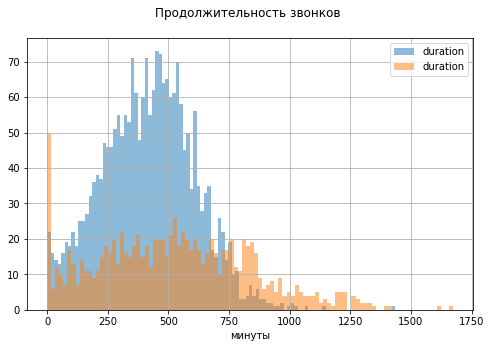

In [34]:
user_data_smart['duration'].hist(bins=100, alpha=0.5, figsize=(8, 5), legend='Smart')
user_data_ultra['duration'].hist(bins=100, alpha=0.5, figsize=(8, 5), legend='Ultra')
plt.title('Продолжительность звонков \n')
plt.xlabel('минуты')

    В трифе Smart 1/3 абонентов превышают бесплатный порог в 500 минут. В тарифе Ultra не используют и половины оплаченного времени в 3000 минут.
    В тарифе Ultra продолжительность звонков распределено более равномерно. 

Сравним количество сообщений в обоих тарифах.

Text(0.5, 0, 'штук')

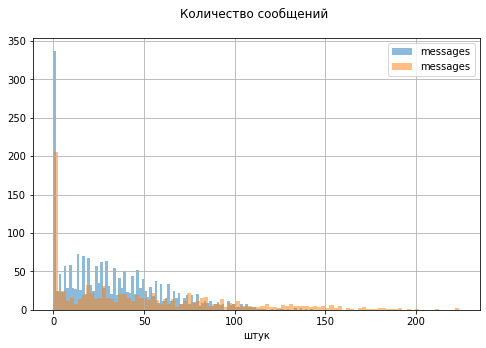

In [35]:
user_data_smart['messages'].hist(bins=100, alpha=0.5, figsize=(8, 5), legend='Smart')
user_data_ultra['messages'].hist(bins=100, alpha=0.5, figsize=(8, 5), legend='Ultra')
plt.title('Количество сообщений \n')
plt.xlabel('штук')

    В основном количество сообщений не превышает 10 штук, только в тарифе Ultra оно на 43 % ниже. 1/3 абонентов Smart превышают бесплатный порог в 50 сообщений. В Ultra не используют и 1/5 от 1000. 

Сравним интернет-график на обоих тарифах.

Text(0.5, 0, 'Гигабайты')

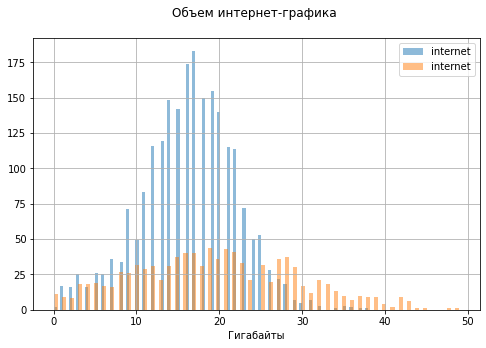

In [36]:
user_data_smart['internet'].hist(bins=100, alpha=0.5, figsize=(8, 5), legend='Smart')
user_data_ultra['internet'].hist(bins=100, alpha=0.5, figsize=(8, 5), legend='Ultra')
plt.title('Объем интернет-графика \n')
plt.xlabel('Гигабайты')

    В тарифе Smart большинство абонентов имеют объем интернет-графика в районе 15 Гбт и половина абонентов превышают этот бесплатный порог. В тарифе Ultra полько 1/5 привышает бесплатный порог в 30 Гбт.

Сравним помесячную выручку с пользователей обоих тарифов.

Text(0.5, 0, 'рубли')

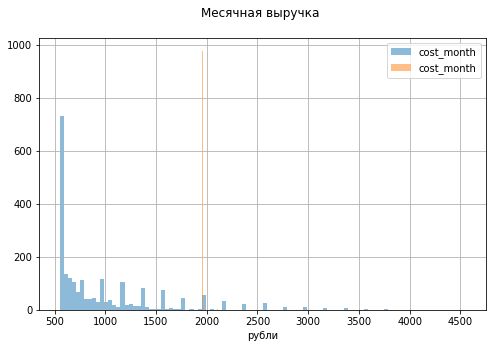

In [37]:
user_data_smart['cost_month'].hist(bins=100, alpha=0.5, figsize=(8, 5), legend='Smart')
user_data_ultra['cost_month'].hist(bins=100, alpha=0.5, figsize=(8, 5), legend='Ultra')
plt.title('Месячная выручка \n')
plt.xlabel('рубли')

    В обоих тарифах месячная выручка в основном состоит из месячной абонентской платы, но в тарифе Smart значительную прибавку выручки составляет доплаты за перерасход включенного в тариф бесплатного трафика.

## Проверим гипотезы

* **средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются**   

Выдвинем гипотезы.
   * Нулевая гипотеза - Средняя выручка пользователей тарифов «Ультра» и «Смарт» одинаковые.
   * Альтернативная гипотеза - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

In [38]:
#зададим уровнень статистической значимости
alpha = 0.01

#проверяем гипотезу о равенстве средних двух совокупностей
results = st.ttest_ind(user_data_smart['cost_month'], user_data_ultra['cost_month'], equal_var=False)

print('р-значение', results.pvalue)

#сравниваем получившееся p-значение с заданным уровнем статистической значимости
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

р-значение 0.0
Отвергаем нулевую гипотезу


Следовательно средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

* **средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов**

Выдвинем гипотезы.
   * Нулевая гипотеза - средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.
   * Альтернативная гипотеза - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [39]:
#объединим две таблицы с разными тарифами в одну
user_data = pd.concat([user_data_smart, user_data_ultra], ignore_index=True)

In [40]:
#создадим две таблицы с нужными условиями
user_data_moscow = user_data.query('city == "Москва"')
user_data_no_moscow = user_data.query('city != "Москва"')

#проверяем гипотезу о равенстве средних двух совокупностей
results = st.ttest_ind(user_data_moscow['cost_month'], user_data_no_moscow['cost_month'], equal_var=False)

print('р-значение', results.pvalue)

#сравниваем получившееся p-значение с заданным уровнем статистической значимости
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

р-значение 0.0043550027101512965
Отвергаем нулевую гипотезу


Следовательно средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

## Общий вывод

   В начале проекта загрузили все данные, округлили время звонка и интернет сессии в соотверствии с тарифом. Удалили пустые значения и привели к нужному типу данных. Посчитали для каждого пользователя: количество сделанных звонков и израсходованных минут разговора по месяцам, количество отправленных сообщений по месяцам, объем израсходованного интернет-трафика по месяцам, помесячную выручку с каждого пользователя. Объединили несколько таблиц в одну для дальнейшей работы. Разбили данные в зависимости от тарифа: Smart и Ultra и проанализировали их.
    Посчитали среднее, дисперсию и стандартное отклонение. Построили гистограммы и пришли к выводу. 
   * В трифе Smart 1/3 абонентов превышают бесплатный порог в 500 минут. В тарифе Ultra не используют и половины оплаченного времени в 3000 минут. 
   * В основном количество сообщений не превышает 10 штук, только в тарифе Ultra оно на 43 % ниже. 1/3 абонентов Smart превышают бесплатный порог в 50 сообщений. В Ultra не используют и 1/5 от 1000.
   * В тарифе Smart большинство абонентов имеют объем интернет-графика в районе 15 Гбт и половина абонентов превышают этот бесплатный порог. В тарифе Ultra полько 1/5 привышает бесплатный порог в 30 Гбт.
   * В обоих тарифах месячная выручка в основном состоит из месячной абонентской платы, но в тарифе Smart значительную прибавку выручки составляет доплаты за перерасход включенного в тариф бесплатного трафика.
    
    Выдвинули и подтвердили гипотезы.
   * Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.
   * Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
    
    В итоге мы пришли к следующим выводам.
   * Средняя месячная выручка на тарифе Ultra составляет 1954 рубля, а тарифе Smart только 953 рубля (в 2 раза меньше), но за счет большего числа абонентов (985 месячных выплат на Ultra и 2229 на Smart) на тарифе Smart суммарная месячная выручка на 10 % больше (1924800 на Ultra и 2123901 на Smart).